### Cargar Librerias

In [34]:
try:
    import keras_tuner
except ImportError:
    print("Se instalara el paquete keras_tuner")
    %pip install keras-tuner # type: ignore 

In [35]:
# Importaciones generales
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de advertencias
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# TensorFlow y Keras
# ==============================================================================
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, LSTM, Dropout # type: ignore
from tensorflow.keras import Sequential  # type: ignore
from tensorflow.keras.losses import Huber # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
import keras_tuner as kt

# Preprocesamiento de datos
# ==============================================================================
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Acceso a bases de datos
# ==============================================================================
from Get_data import DatabaseManager

### Cargar Datos

In [36]:
db_manager = DatabaseManager()
db_manager.update_database(city='Piura') 
df = db_manager.get_combined_dataframe()
df = df.dropna(axis=1, how='all')

Database is already up to date.


In [37]:
df.columns

Index(['id_ciudad', 'dia', 'temp_max', 'temp_min', 'avg_temp', 'precp',
       'direc_viento', 'vel_viento', 'presion'],
      dtype='object')

### Analisis de los datos

In [38]:
df.head()

,id_ciudad,dia,temp_max,temp_min,avg_temp,precp,direc_viento,vel_viento,presion
0,1,2018-07-25,29.5,17.8,20.1,NaN,173,11.9,1015.0
1,1,2018-07-26,27.3,17.1,20.8,NaN,174,12.8,1015.2
2,1,2018-07-27,27.7,17.6,20.7,NaN,177,12.8,1015.0
3,1,2018-07-28,27.8,17.9,21.1,NaN,175,12.9,1015.3
4,1,2018-07-29,28.4,17.4,20.4,NaN,174,12.8,1015.4


In [39]:
df.describe()

,id_ciudad,dia,temp_max,temp_min,avg_temp,precp,direc_viento,vel_viento,presion
count,2297.0,2297,2297.000000,2297.000000,2297.000000,931.000000,2297.000000,2297.000000,2297.000000
mean,1.0,2021-09-15 00:00:00,30.502090,19.574010,24.041532,1.185285,183.400958,13.798999,1012.654549
min,1.0,2018-07-25 00:00:00,24.400000,2.000000,17.900000,0.000000,15.000000,5.500000,1007.300000
25%,1.0,2020-02-19 00:00:00,28.400000,17.200000,21.600000,0.000000,177.000000,12.700000,1011.500000
50%,1.0,2021-09-15 00:00:00,30.200000,19.300000,23.700000,0.000000,181.000000,13.900000,1012.700000
75%,1.0,2023-04-12 00:00:00,32.600000,22.000000,26.500000,0.000000,187.000000,15.200000,1013.900000
max,1.0,2024-11-06 00:00:00,37.800000,26.000000,31.800000,80.000000,357.000000,27.800000,1016.700000
std,0.0,NaN,2.487989,2.811921,2.872912,4.640952,16.555415,2.176048,1.698733


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id_ciudad     2297 non-null   int64         
 1   dia           2297 non-null   datetime64[ns]
 2   temp_max      2297 non-null   float64       
 3   temp_min      2297 non-null   float64       
 4   avg_temp      2297 non-null   float64       
 5   precp         931 non-null    float64       
 6   direc_viento  2297 non-null   int64         
 7   vel_viento    2297 non-null   float64       
 8   presion       2297 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 161.6 KB


In [41]:
print('Datos antes del filtrado: ')
print(df[df['precp'] < 0.5]['precp'].value_counts())
df['precp'] = df['precp'].fillna(0)

print('\nDatos post filtración: ')
print(df[df['precp'] < 0.5]['precp'].value_counts())

Datos antes del filtrado: 
precp
0.0    715
0.2     17
0.1     13
0.3     12
0.4      8
Name: count, dtype: int64

Datos post filtración: 
precp
0.0    2081
0.2      17
0.1      13
0.3      12
0.4       8
Name: count, dtype: int64


In [42]:
# Media absoluta de la desviación usando la mediana
df.iloc[:,2:9].apply(lambda x: np.mean(np.abs(x-np.median(x))),axis=0)

temp_max        2.130300
temp_min        2.401916
avg_temp        2.488333
precp           0.480409
direc_viento    7.394428
vel_viento      1.647976
presion         1.382673
dtype: float64

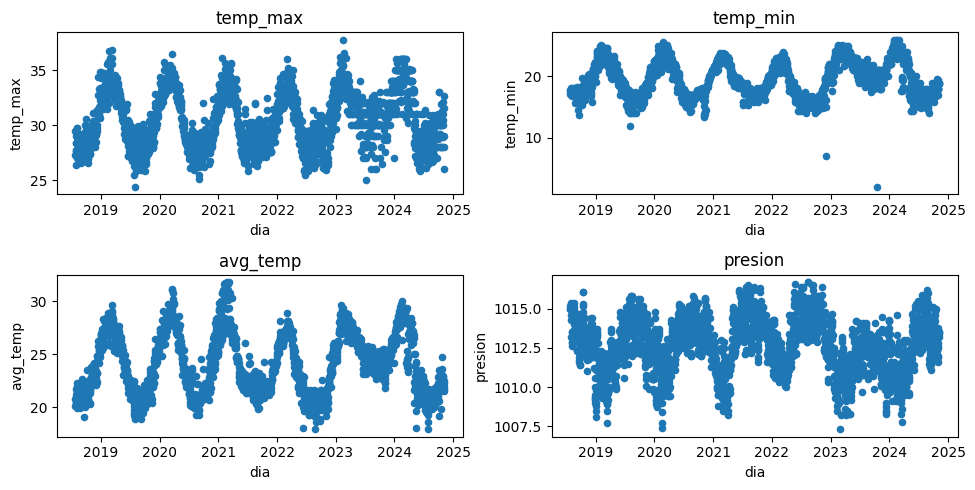

In [43]:
# Definimos la lista de columnas que queremos graficar
columnas_a_graficar = ['temp_max', 'temp_min', 'avg_temp', 'presion']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes = axes.flat

# Graficar cada columna en la lista
for ncol, colname in enumerate(columnas_a_graficar):
    if colname in df.columns: 
        df.plot(x='dia', y=colname, kind='scatter', ax=axes[ncol])
        axes[ncol].set_title(colname) 
    else:
        print(f"Columna '{colname}' no encontrada en el DataFrame.")

plt.tight_layout() 
plt.show()


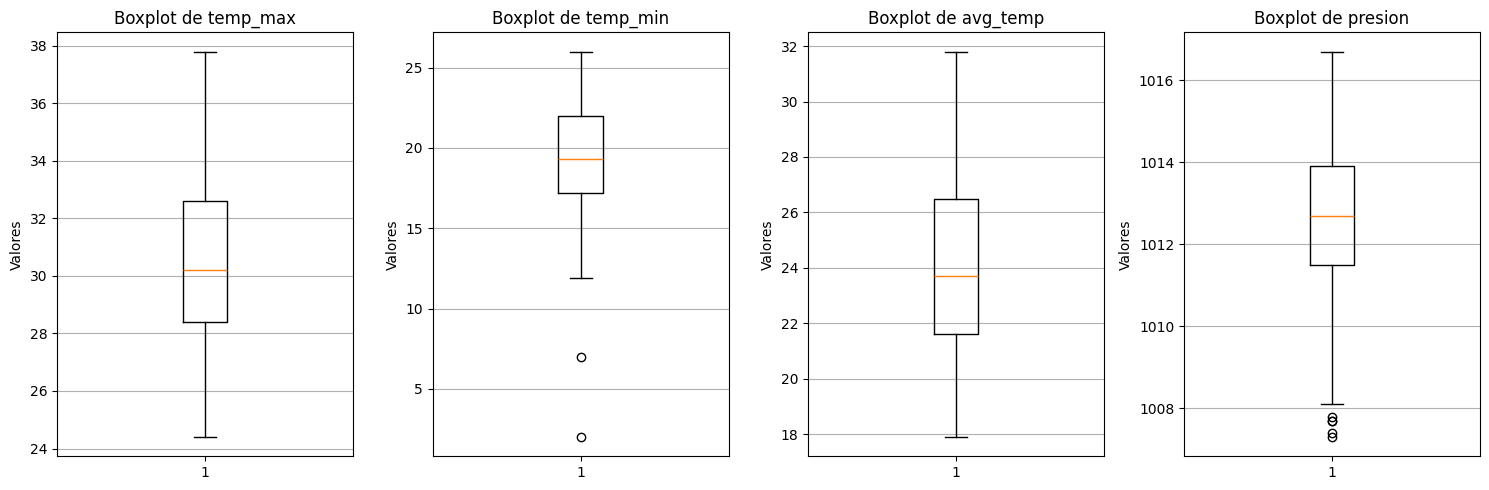

In [44]:
# Crear subplots
fig, axs = plt.subplots(1, len(columnas_a_graficar), figsize=(15, 5))  

# Crear boxplots horizontales
for ax, columna in zip(axs, columnas_a_graficar):
    ax.boxplot(df[columna])
    ax.set_title(f'Boxplot de {columna}')
    ax.set_ylabel('Valores')
    ax.grid(axis='y') 

plt.tight_layout() 
plt.show()

In [45]:
mean_temp_min = df['temp_min'].mean()
df['temp_min'] = df['temp_min'].apply(lambda x: mean_temp_min if x < 10 else x)

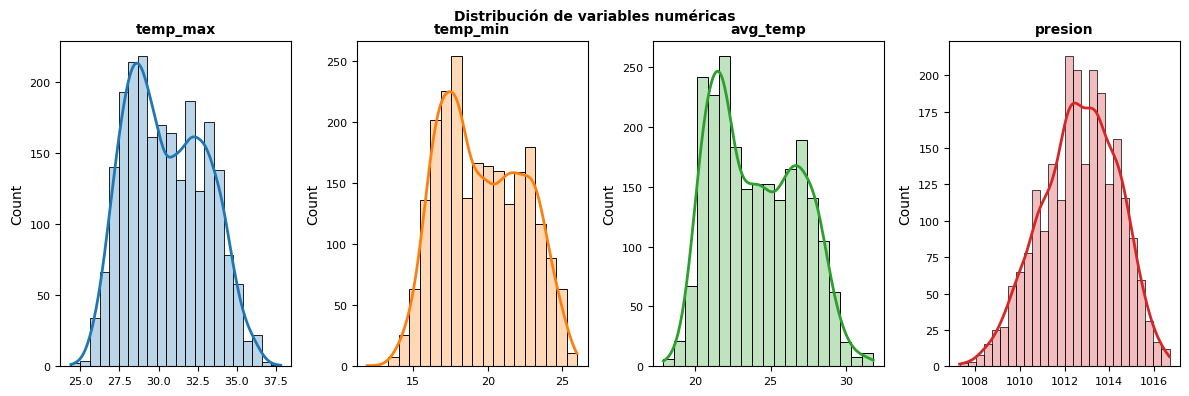

In [46]:
selected_columns = ['temp_max', 'temp_min', 'avg_temp', 'presion']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
axes = axes.flat

for i, column in enumerate(selected_columns):
    sns.histplot(
        data=df,
        x=column,
        stat="count",
        kde=True,
        color=(list(plt.rcParams['axes.prop_cycle'])*2)[i % 10]["color"],
        line_kws={'linewidth': 2},
        alpha=0.3,
        ax=axes[i]
    )
    axes[i].set_title(column, fontsize=10, fontweight="bold")
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de variables numéricas', fontsize=10, fontweight="bold")
plt.show()


In [47]:
df[['temp_max', 'temp_min', 'avg_temp', 'presion']].corr()

,temp_max,temp_min,avg_temp,presion
temp_max,1.000000,0.821406,0.891853,-0.675489
temp_min,0.821406,1.000000,0.923837,-0.673543
avg_temp,0.891853,0.923837,1.000000,-0.696861
presion,-0.675489,-0.673543,-0.696861,1.000000


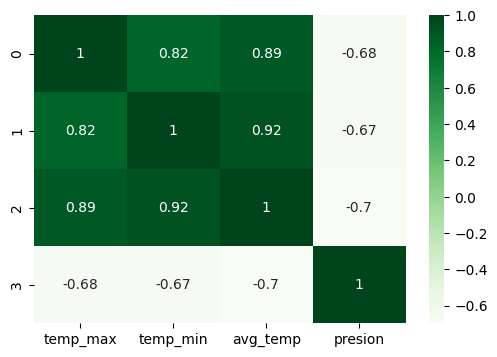

In [48]:
corr = df[['temp_max', 'temp_min', 'avg_temp', 'presion']].corr().reset_index(drop=True)
plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

### Entrenamiento del modelo

#### Preparar los datos de entrenamiento

In [49]:
features = ['temp_max', 'temp_min', 'avg_temp', 'presion']
df_train = df[df['dia'] <= '2023-12-31']
df_val = df[(df['dia'] > '2023-12-31') & (df['dia'] <= '2024-06-30')] 
print(f'La data de entrenamiento tiene {len(df_train)} filas')
print(f'La data de validación tiene {len(df_val)} filas')

La data de entrenamiento tiene 1986 filas
La data de validación tiene 182 filas


In [50]:
# Estandarizamos las bases de datos de entrenamiento y validación
scaler = RobustScaler()
scaler.fit(df_train[features].values)

# Transformamos los datos de entrenamiento
df_train_esc = scaler.transform(df_train[features].values)

# Transformamos los datos de validación
df_val_esc = scaler.transform(df_val[features].values)

# Imprimimos las formas de los DataFrames estandarizados
print(df_train_esc.shape)
print(df_val_esc.shape)

(1986, 4)
(182, 4)


In [51]:
# Función para crear secuencias de datos
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [52]:
window_size = 30
x_train, y_train = create_sequences(df_train_esc, window_size)
x_val, y_val = create_sequences(df_val_esc, window_size)

y_train, y_val = y_train[:,0:3], y_val[:,0:3]
print(f'Tamaño de x_train es : {x_train.shape}')
print(f'Tamaño de y_train es : {y_train.shape}')
print(f'Tamaño de x_val es   : {x_val.shape}')
print(f'Tamaño de y_val es   : {y_val.shape}')

Tamaño de x_train es : (1956, 30, 4)
Tamaño de y_train es : (1956, 3)
Tamaño de x_val es   : (152, 30, 4)
Tamaño de y_val es   : (152, 3)


In [53]:
# Calcular la varianza de los datos de entrenamiento y validación
var_y_train = np.var(y_train, axis=0)
var_y_val = np.var(y_val, axis=0)

print(f'Varianza de y_train: {var_y_train}')
print(f'Varianza de y_val: {var_y_val}')

Varianza de y_train: [0.36851024 0.34099378 0.33947114]
Varianza de y_val: [0.54526313 0.47383605 0.42303775]


#### Entrenar modelo

In [54]:
"""
# Definir la función de modelo
def build_model(hp):
    model = Sequential()
    
    # Capa LSTM con un número de neuronas variable
    model.add(LSTM(
        units=hp.Int('units', min_value=5, max_value=50, step=5),
        input_shape=(window_size, df_train_esc.shape[1]),
        kernel_regularizer=l2(hp.Choice('l2_reg', values=[0.001, 0.005, 0.01])),
        return_sequences=False
    ))
    
    # Dropout con un valor ajustable
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Capa densa de salida
    model.add(Dense(3, activation='linear'))
    
    # Compilación del modelo con un optimizador configurable
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss=Huber(),
        metrics=['mae', 'mse']
    )
    
    return model

# Crear el objeto de búsqueda
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning'
)

# Callbacks para detener el entrenamiento temprano y restaurar el mejor modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Realizar la búsqueda de hiperparámetros
tuner.search(x_train, y_train, 
             validation_data=(x_val, y_val),
             epochs=100,
             batch_size=16,
             callbacks=[early_stopping])

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Mejor número de unidades LSTM: {best_hps.get('units')}")
print(f"Mejor regularización L2: {best_hps.get('l2_reg')}")
print(f"Mejor tasa de dropout: {best_hps.get('dropout_rate')}")
print(f"Mejor tasa de aprendizaje: {best_hps.get('learning_rate')}")

# Entrenar el mejor modelo
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, 
                         validation_data=(x_val, y_val),
                         epochs=100,
                         batch_size=16,
                         callbacks=[early_stopping])
"""

'\n# Definir la función de modelo\ndef build_model(hp):\n    model = Sequential()\n    \n    # Capa LSTM con un número de neuronas variable\n    model.add(LSTM(\n        units=hp.Int(\'units\', min_value=5, max_value=50, step=5),\n        input_shape=(window_size, df_train_esc.shape[1]),\n        kernel_regularizer=l2(hp.Choice(\'l2_reg\', values=[0.001, 0.005, 0.01])),\n        return_sequences=False\n    ))\n    \n    # Dropout con un valor ajustable\n    model.add(Dropout(hp.Float(\'dropout_rate\', min_value=0.2, max_value=0.5, step=0.1)))\n    \n    # Capa densa de salida\n    model.add(Dense(3, activation=\'linear\'))\n    \n    # Compilación del modelo con un optimizador configurable\n    model.compile(\n        optimizer=Adam(learning_rate=hp.Choice(\'learning_rate\', values=[1e-2, 1e-3, 1e-4])),\n        loss=Huber(),\n        metrics=[\'mae\', \'mse\']\n    )\n    \n    return model\n\n# Crear el objeto de búsqueda\ntuner = kt.Hyperband(\n    build_model,\n    objective=\'val_

In [55]:
# Crear el modelo LSTM
model = Sequential()

# Capa LSTM con más neuronas y regularización L2
model.add(LSTM(30, 
               input_shape=(window_size, df_train_esc.shape[1]), 
               kernel_regularizer=l2(0.001),
               return_sequences=False))

# Dropout para evitar sobreajuste
model.add(Dropout(0.2))

# Capa densa con 3 salidas 
model.add(Dense(3, activation='linear'))  # 'linear' para regresión

# Compilación del modelo
model.compile(optimizer='adam', loss=Huber(), metrics=['mae', 'mse'])

# Definición de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Definición del planificador de tasa de aprendizaje
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.8  # Reducir la tasa de aprendizaje en un 30% cada 10 épocas
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Entrenamiento del modelo
history = model.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    epochs=100, 
                    batch_size=16,
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1374 - mae: 0.3992 - mse: 0.2657 - val_loss: 0.0752 - val_mae: 0.2888 - val_mse: 0.1408 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0383 - mae: 0.1959 - mse: 0.0675 - val_loss: 0.0640 - val_mae: 0.2558 - val_mse: 0.1217 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0326 - mae: 0.1845 - mse: 0.0587 - val_loss: 0.0613 - val_mae: 0.2526 - val_mse: 0.1178 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0304 - mae: 0.1791 - mse: 0.0558 - val_loss: 0.0608 - val_mae: 0.2501 - val_mse: 0.1179 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0304 - mae: 0.1811 - mse: 0.0567 - val_loss: 0.0592 - val_mae: 0.2486 - val_mse: 0.1153 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0283 - mae: 0.1725 - mse: 0.0532 - val_loss: 0.0594 - val_mae

In [56]:
# Evaluación del modelo en el conjunto de validación
loss, mae, mse = model.evaluate(x_val, y_val)

# Imprimir los resultados
print(f'Pérdida en validación (Huber Loss): {loss:.4f}')
print(f'MAE en validación (Error Absoluto Medio): {mae:.4f}')
print(f'MSE en validación (Error Cuadrático Medio): {mse:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - mae: 0.2414 - mse: 0.1094 
Pérdida en validación (Huber Loss): 0.0567
MAE en validación (Error Absoluto Medio): 0.2437
MSE en validación (Error Cuadrático Medio): 0.1124


In [ ]:
"""
Prueba actual:
MAE: 0.24321879632054713 ~
RMSE: 0.33564318330897197 ~
"""
# Predicciones
y_pred = model.predict(x_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
MAE: 0.2436989178598374
RMSE: 0.3352925529170057


In [58]:
# Función para graficar la evolución de la pérdida, MAE y MSE con un rango de épocas
def plot_training_history(history, epoch_start=0, epoch_end=None, tamaño=0.01):
    # Determinar el rango de épocas
    if epoch_end is None:
        epoch_end = len(history.history['loss'])
    
    # Graficar la pérdida, MAE y MSE
    plt.figure(figsize=(18, 5))
    
    # Gráfico de la pérdida
    plt.subplot(1, 3, 1)
    plt.plot(range(epoch_start, epoch_end), history.history['loss'][epoch_start:epoch_end], label='Pérdida de Entrenamiento')
    plt.plot(range(epoch_start, epoch_end), history.history['val_loss'][epoch_start:epoch_end], label='Pérdida de Validación')
    plt.title('Evolución de la Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Inicial: {history.history["loss"][epoch_start]:.4f}', 
                 xy=(epoch_start, history.history['loss'][epoch_start]), 
                 xytext=(epoch_start, history.history['loss'][epoch_start] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))
    plt.annotate(f'Final: {history.history["loss"][epoch_end - 1]:.4f}', 
                 xy=(epoch_end - 1, history.history['loss'][epoch_end - 1]), 
                 xytext=(epoch_end - 1, history.history['loss'][epoch_end - 1] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))

    # Gráfico del MAE
    plt.subplot(1, 3, 2)
    plt.plot(range(epoch_start, epoch_end), history.history['mae'][epoch_start:epoch_end], label='MAE de Entrenamiento')
    plt.plot(range(epoch_start, epoch_end), history.history['val_mae'][epoch_start:epoch_end], label='MAE de Validación')
    plt.title('Evolución del MAE')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Inicial: {history.history["mae"][epoch_start]:.4f}', 
                 xy=(epoch_start, history.history['mae'][epoch_start]), 
                 xytext=(epoch_start, history.history['mae'][epoch_start] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))
    plt.annotate(f'Final: {history.history["mae"][epoch_end - 1]:.4f}', 
                 xy=(epoch_end - 1, history.history['mae'][epoch_end - 1]), 
                 xytext=(epoch_end - 1, history.history['mae'][epoch_end - 1] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))

    # Gráfico del MSE
    plt.subplot(1, 3, 3)
    plt.plot(range(epoch_start, epoch_end), history.history['mse'][epoch_start:epoch_end], label='MSE de Entrenamiento')
    plt.plot(range(epoch_start, epoch_end), history.history['val_mse'][epoch_start:epoch_end], label='MSE de Validación')
    plt.title('Evolución del MSE')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Inicial: {history.history["mse"][epoch_start]:.4f}', 
                 xy=(epoch_start, history.history['mse'][epoch_start]), 
                 xytext=(epoch_start, history.history['mse'][epoch_start] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))
    plt.annotate(f'Final: {history.history["mse"][epoch_end - 1]:.4f}', 
                 xy=(epoch_end - 1, history.history['mse'][epoch_end - 1]), 
                 xytext=(epoch_end - 1, history.history['mse'][epoch_end - 1] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.tight_layout()
    plt.show()


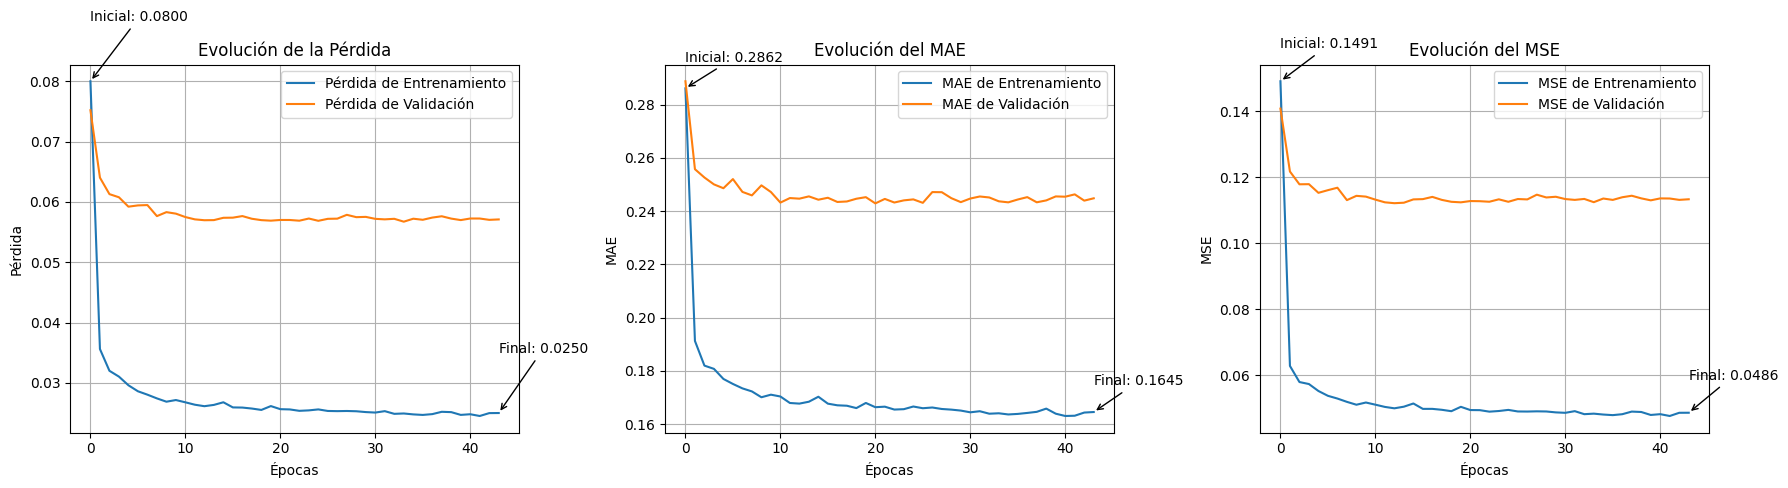

In [59]:
# Llamada a la función para graficar el historial
plot_training_history(history, epoch_start=0, epoch_end=None, tamaño=0.01)

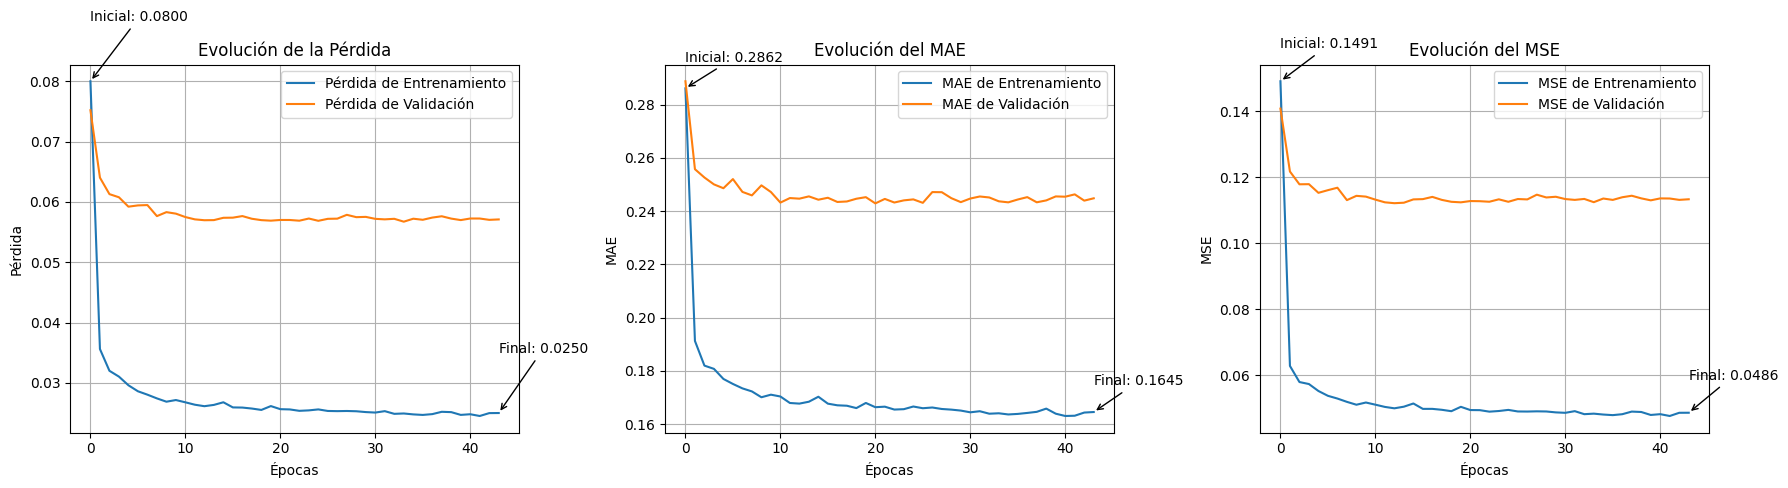

In [60]:
# Llamada a la función para graficar desde un intervalo "mas optimo"
plot_training_history(history, epoch_start=0, epoch_end=None, tamaño=0.01)

#### Evaluacion del modelo

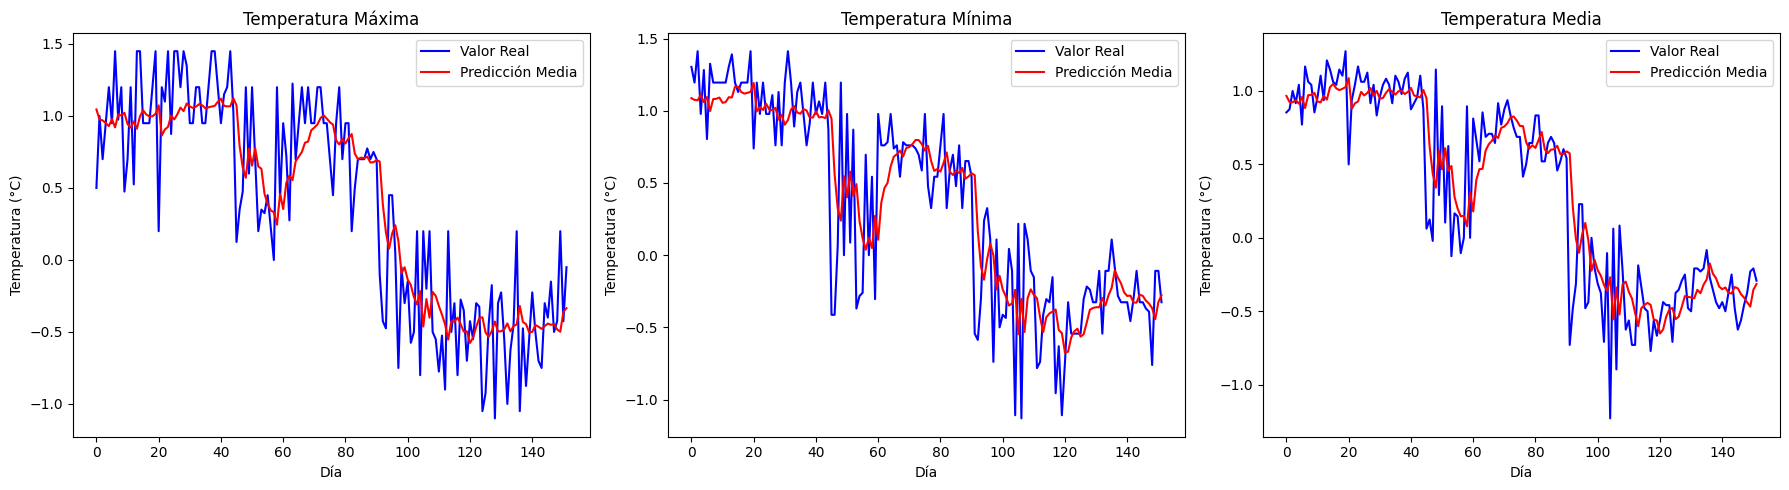

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperatura máxima
axes[0].plot(y_val[:, 0], label='Valor Real', color='blue')
axes[0].plot(y_pred[:, 0], label='Predicción Media', color='red')
axes[0].set_title('Temperatura Máxima')
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Temperatura (°C)')
axes[0].legend()

# Temperatura mínima
axes[1].plot(y_val[:, 1], label='Valor Real', color='blue')
axes[1].plot(y_pred[:, 1], label='Predicción Media', color='red')
axes[1].set_title('Temperatura Mínima')
axes[1].set_xlabel('Día')
axes[1].set_ylabel('Temperatura (°C)')
axes[1].legend()

# Temperatura media
axes[2].plot(y_val[:, 2], label='Valor Real', color='blue')
axes[2].plot(y_pred[:, 2], label='Predicción Media', color='red')
axes[2].set_title('Temperatura Media')
axes[2].set_xlabel('Día')
axes[2].set_ylabel('Temperatura (°C)')
axes[2].legend()

plt.tight_layout()
plt.show()

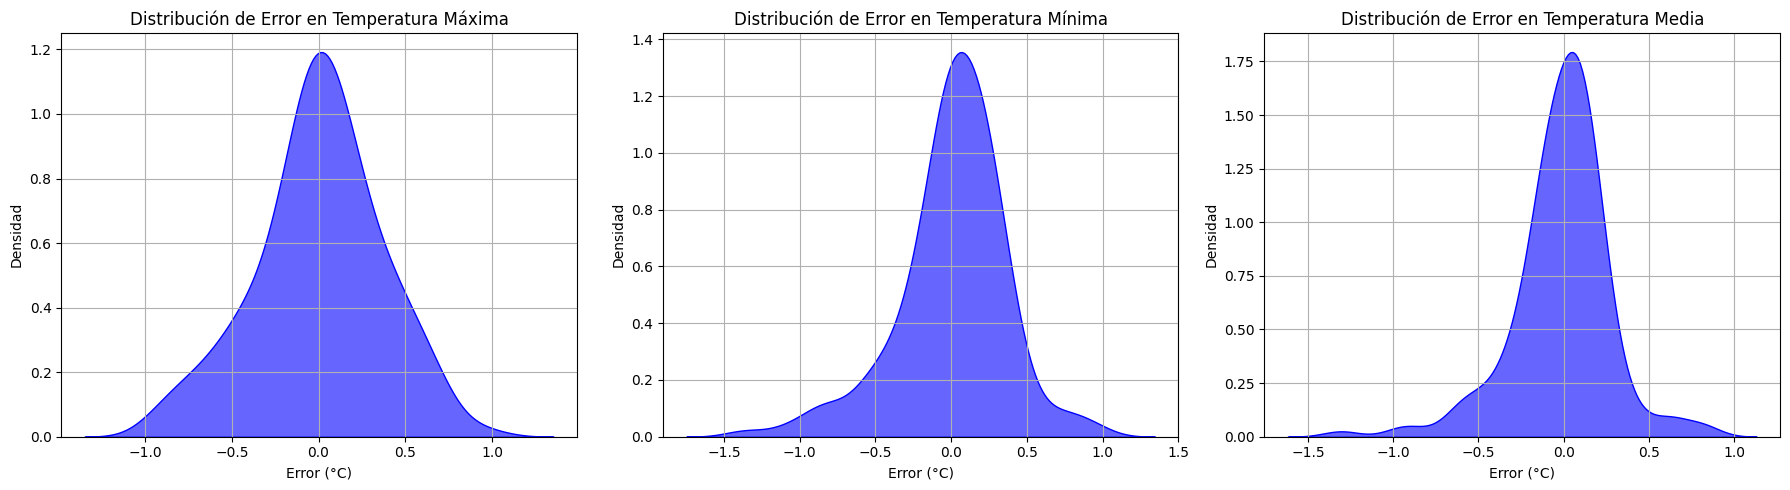

In [62]:
# Calcular el error entre los valores reales y las predicciones
error_max = y_val[:, 0] - y_pred[:, 0]
error_min = y_val[:, 1] - y_pred[:, 1]
error_media = y_val[:, 2] - y_pred[:, 2]

# Graficar la distribución de los errores usando KDE (Kernel Density Estimation)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribución de error en temperatura máxima (KDE)
sns.kdeplot(error_max, ax=axes[0], color='blue', fill=True, alpha=0.6)
axes[0].set_title('Distribución de Error en Temperatura Máxima')
axes[0].set_xlabel('Error (°C)')
axes[0].set_ylabel('Densidad')
axes[0].grid(True)

# Distribución de error en temperatura mínima (KDE)
sns.kdeplot(error_min, ax=axes[1], color='blue', fill=True, alpha=0.6)
axes[1].set_title('Distribución de Error en Temperatura Mínima')
axes[1].set_xlabel('Error (°C)')
axes[1].set_ylabel('Densidad')
axes[1].grid(True)

# Distribución de error en temperatura media (KDE)
sns.kdeplot(error_media, ax=axes[2], color='blue', fill=True, alpha=0.6)
axes[2].set_title('Distribución de Error en Temperatura Media')
axes[2].set_xlabel('Error (°C)')
axes[2].set_ylabel('Densidad')
axes[2].grid(True)

plt.tight_layout()
plt.show()

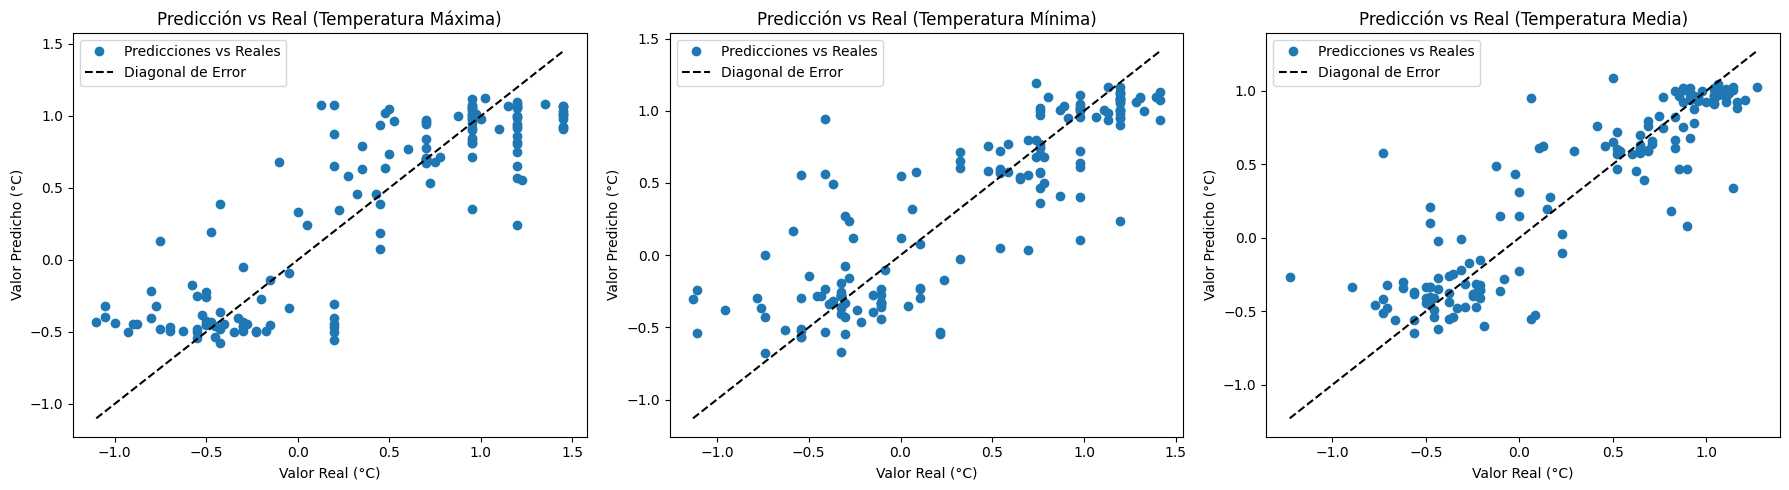

In [63]:
# Graficar la diagonal de error (predicciones vs reales)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Diagonal de error para temperatura máxima
axes[0].plot(y_val[:, 0], y_pred[:, 0], 'o', label='Predicciones vs Reales')
axes[0].plot([min(y_val[:, 0]), max(y_val[:, 0])], [min(y_val[:, 0]), max(y_val[:, 0])], 'k--', label='Diagonal de Error')
axes[0].set_title('Predicción vs Real (Temperatura Máxima)')
axes[0].set_xlabel('Valor Real (°C)')
axes[0].set_ylabel('Valor Predicho (°C)')
axes[0].legend()

# Diagonal de error para temperatura mínima
axes[1].plot(y_val[:, 1], y_pred[:, 1], 'o', label='Predicciones vs Reales')
axes[1].plot([min(y_val[:, 1]), max(y_val[:, 1])], [min(y_val[:, 1]), max(y_val[:, 1])], 'k--', label='Diagonal de Error')
axes[1].set_title('Predicción vs Real (Temperatura Mínima)')
axes[1].set_xlabel('Valor Real (°C)')
axes[1].set_ylabel('Valor Predicho (°C)')
axes[1].legend()

# Diagonal de error para temperatura media
axes[2].plot(y_val[:, 2], y_pred[:, 2], 'o', label='Predicciones vs Reales')
axes[2].plot([min(y_val[:, 2]), max(y_val[:, 2])], [min(y_val[:, 2]), max(y_val[:, 2])], 'k--', label='Diagonal de Error')
axes[2].set_title('Predicción vs Real (Temperatura Media)')
axes[2].set_xlabel('Valor Real (°C)')
axes[2].set_ylabel('Valor Predicho (°C)')
axes[2].legend()

plt.tight_layout()
plt.show()


In [64]:
# Calcular RMSE para cada variable
rmse_max = np.sqrt(np.mean(error_max**2))
rmse_min = np.sqrt(np.mean(error_min**2))
rmse_media = np.sqrt(np.mean(error_media**2))

# Imprimir los valores de RMSE
print(f'RMSE para Temperatura Máxima: {rmse_max}')
print(f'RMSE para Temperatura Mínima: {rmse_min}')
print(f'RMSE para Temperatura Media: {rmse_media}')

RMSE para Temperatura Máxima: 0.36217441692642116
RMSE para Temperatura Mínima: 0.3535004859267872
RMSE para Temperatura Media: 0.2848339626841249


#### Intervalos de confianza del modelo

In [65]:
# Predicciones con Monte Carlo Dropout
y_preds_mc = [model(x_val, training=True).numpy() for _ in range(1000)]

# Convertir a array de NumPy y calcular la varianza
y_preds_mc = np.array(y_preds_mc)

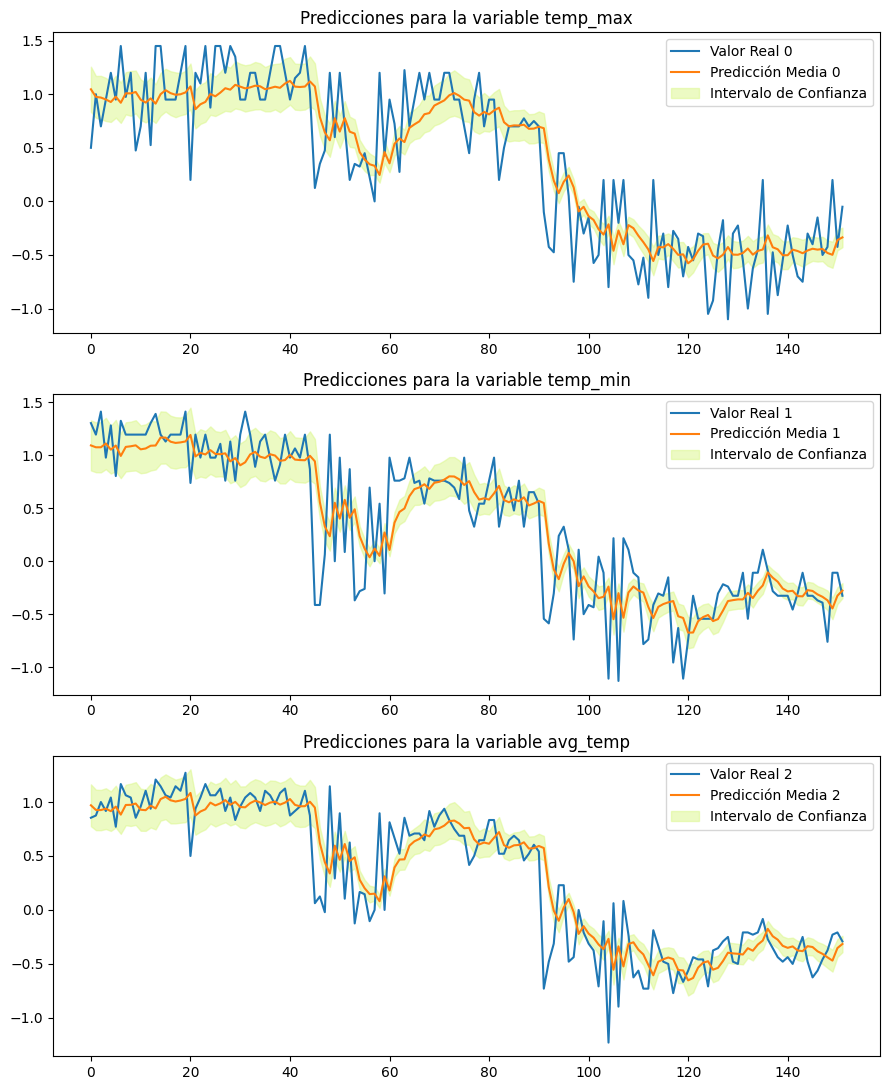

In [66]:
# Visualización de la varianza en las predicciones para 3 variables
fig, axes = plt.subplots(3, 1, figsize=(9, 11))

# Para cada variable
for i in range(3):
    ax = axes[i]
    
    # Calcular la media y la desviación estándar para la variable i
    mean_preds = np.mean(y_preds_mc, axis=0)[:, i]
    std_preds = np.std(y_preds_mc, axis=0)[:, i]
    
    # Calcular los intervalos de confianza para la variable i
    lower_bound = mean_preds - 1.96 * std_preds
    upper_bound = mean_preds + 1.96 * std_preds
    
    # Graficar
    ax.plot(y_val[:, i], label=f'Valor Real {i}')
    ax.plot(mean_preds, label=f'Predicción Media {i}')
    ax.fill_between(range(len(y_val)),
                    lower_bound, upper_bound,
                    color='#daf788', alpha=0.5, label='Intervalo de Confianza')
    
    # Configuración del gráfico
    ax.legend()
    
    # Asignación condicional del título
    if i == 0:
        ax.set_title('Predicciones para la variable temp_max')
    elif i == 1:
        ax.set_title('Predicciones para la variable temp_min')
    else:
        ax.set_title('Predicciones para la variable avg_temp')

plt.tight_layout()
plt.show()

### Guardar Modelo

In [69]:
model.save('Modelo_Entrenado.keras')